In [317]:
from collections import Counter

import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap

from NEExT.builders import EmbeddingBuilder
from NEExT.collections import EgonetCollection
from NEExT.features import NodeFeatures, StructuralNodeFeatures
from NEExT.io import GraphIO

%reload_ext autoreload
%autoreload 2

# Setup data

In [ ]:
DATASET = "mirrored-zachary"


# lines

if DATASET == "zachary":
    g_zac = ig.Graph.Famous("zachary")
    g_zac.vs["comm"] = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
elif DATASET == "mirrored-zachary":
    with open("small_data/karate-mirrored") as f:
        lines = f.readlines()

    lines = [[int(char) - 1 for char in line.replace("\n", "").split(" ")] for line in lines]
    g_zac = ig.Graph(edges=lines)
    g_zac.vs["comm"] = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] * 2

elif DATASET == "barbell":
    with open("small_data/barbell") as f:
        lines = f.readlines()

    lines = [[int(char) for char in line.replace("\n", "").split(" ")] for line in lines]
    g_zac = ig.Graph(edges=lines)
    g_zac.vs["comm"] = [0 for i in range(9)] + [1, 2, 3, 4, 5, 6, 6, 5, 4, 3, 2, 1] + [0 for i in range(9)]

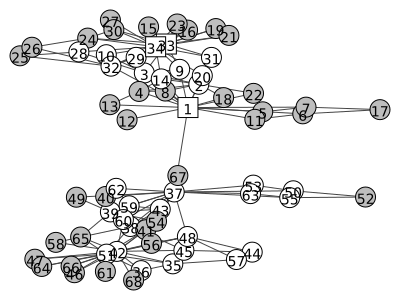

In [319]:
colors = ["white", "gray", "dimgray", "blue"]


## normalized within-module degree (z(v))
def nwmd(G, A):
    # within module degrees
    deg_in = [sum([A[v] == A[i] for i in G.neighbors(v)]) for v in range(G.vcount())]
    deg_in_mean = [np.mean([deg_in[i] for i in range(G.vcount()) if A[i] == j]) for j in set(A)]
    deg_in_std = [np.std([deg_in[i] for i in range(G.vcount()) if A[i] == j], ddof=1) for j in set(A)]
    return [(deg_in[v] - deg_in_mean[A[v]]) / deg_in_std[A[v]] for v in range(G.vcount())]


## participation coefficient
def pc(G, A):
    deg = G.degree()
    coef = []
    for v in range(G.vcount()):
        coef.append(1 - np.sum([(x / deg[v]) ** 2 for x in Counter([A[i] for i in G.neighbors(v)]).values()]))
    return coef


g_zac.vs["z"] = nwmd(g_zac, g_zac.vs["comm"])
g_zac.vs["p"] = pc(g_zac, g_zac.vs["comm"])
g_zac.vs["color"] = colors[3]
g_zac.vs["shape"] = "circle"
g_zac.vs["label"] = g_zac.vs["name"] = [str(i + 1) for i in range(g_zac.vcount())]

node_role = []

for v in g_zac.vs:
    if v["z"] < 2.5:  ## non-hub
        if v["p"] <= 0.62 and v["p"] >= 0.05:  ## peripheral
            v["color"] = colors[0]
            node_role.append("peripheral")
        if v["p"] < 0.05:  ## ultra-peripheral
            v["color"] = colors[1]
            node_role.append("ultra-peripheral")
    elif v["z"] >= 2.5 and v["p"] < 0.3:  ## hubs (all provincial here)
        v["color"] = colors[0]
        v["shape"] = "square"
        node_role.append("hub")
    else:
        node_role.append("normal")
g_zac.vs["node_role"] = node_role

ig.plot(g_zac, layout=g_zac.layout_fruchterman_reingold(), bbox=(0, 0, 400, 300))

In [320]:
edges_df = pd.DataFrame(g_zac.get_edgelist())
edges_df.columns = ["src_node_id", "dest_node_id"]

features_df = pd.DataFrame()
features_df.insert(0, "node_id", list(range(g_zac.vcount())))


mapping_df = pd.DataFrame()
mapping_df["node_id"] = list(range(g_zac.vcount()))
mapping_df["graph_id"] = 0

In [321]:
## store the results and sort
df_descript = pd.DataFrame()
df_descript["node_id"], df_descript["z"], df_descript["p"], df_descript["comm"] = g_zac.vs.indices, g_zac.vs["z"], g_zac.vs["p"], g_zac.vs["comm"]
df_descript["hub"] = (df_descript["z"] >= 2.5) & (df_descript["p"] < 0.3)
df_descript["peripherial"] = (df_descript["z"] < 2.5) & (df_descript["p"].between(0.05, 0.62))
df_descript["ultra_peripherial"] = (df_descript["z"] < 2.5) & (df_descript["p"] < 0.05)
df_descript["normal"] = (~df_descript["hub"]) & (~df_descript["peripherial"]) & (~df_descript["ultra_peripherial"])
df_descript["node_role"] = node_role
# D = pd.DataFrame(
#     np.array([g_zac.vs["z"], g_zac.vs["p"]],).transpose(),
#     columns=["z", "p"],
# )
df_descript

,node_id,z,p,comm,hub,peripherial,ultra_peripherial,normal,node_role
0,0,3.688338,0.207612,0,True,False,False,False,hub
1,1,1.314235,0.197531,0,False,True,False,False,peripheral
2,2,0.296763,0.500000,0,False,True,False,False,peripheral
3,3,0.635920,0.000000,0,False,False,True,False,ultra-peripheral
4,4,-0.381552,0.000000,0,False,False,True,False,ultra-peripheral
...,...,...,...,...,...,...,...,...,...
63,63,-0.784025,0.000000,1,False,False,True,False,ultra-peripheral
64,64,-0.784025,0.000000,1,False,False,True,False,ultra-peripheral
65,65,-0.784025,0.000000,1,False,False,True,False,ultra-peripheral
66,66,-0.784025,0.000000,1,False,False,True,False,ultra-peripheral


# Build embeddings

In [322]:
class Config:
    def __init__(self):
        self.k_hop = 1
        self.egonet_feature_target = None
        self.skip_features = []

        self.global_structural_features = dict(
            feature_list=["all"],
            feature_vector_length=5,
        )

        self.egonet_structural_features = dict(
            feature_list=["all"],
            feature_vector_length=self.k_hop,
        )

        self.egonet_node_features = dict(
            feature_list=[],
        )

        # self.embeddings = dict(embeddings_dimension=5, strategy="combined_embeddings")
        self.embeddings = dict(embeddings_dimension=10, strategy="feature_embeddings")
        # self.embeddings = dict(embeddings_dimension=5, strategy="structural_embeddings")


CONFIG = Config()
graph_io = GraphIO()

In [323]:
# Compute global structural node features, add them as graph node features
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
    filter_largest_component=False,
)
global_structural_node_features = StructuralNodeFeatures(
    graph_collection=graph_collection,
    show_progress=False,
    suffix="global",
    feature_list=CONFIG.global_structural_features["feature_list"],
    feature_vector_length=CONFIG.global_structural_features["feature_vector_length"],
).compute()
graph_collection.add_node_features(global_structural_node_features.features_df)

In [324]:
# BUILD EGO NET COLLECTION USING K_HOP ALGOIRHTM
egonet_collection = EgonetCollection(egonet_feature_target=CONFIG.egonet_feature_target, skip_features=CONFIG.skip_features)
egonet_collection.compute_k_hop_egonets(graph_collection, CONFIG.k_hop)


# COMPUTE LOCAL STRUCTURAL NODE FEATURES
structural_node_features = StructuralNodeFeatures(
    graph_collection=egonet_collection,
    show_progress=False,
    suffix="local",
    feature_list=CONFIG.egonet_structural_features["feature_list"],
    feature_vector_length=CONFIG.egonet_structural_features["feature_vector_length"],
)
structural_features = structural_node_features.compute()

# Build egonet node features object
node_features = NodeFeatures(
    egonet_collection,
    feature_list=global_structural_node_features.feature_columns + CONFIG.egonet_node_features["feature_list"],
    show_progress=False,
)
features = node_features.compute()

In [325]:
emb_builder = EmbeddingBuilder(
    graph_collection=egonet_collection,
    structural_features=structural_features,
    features=features,
    embeddings_dimension=CONFIG.embeddings["embeddings_dimension"],
)
embeddings = emb_builder.compute(CONFIG.embeddings["strategy"])

In [326]:
def plot(x, y, hue=None, palette="viridis"):
    jitter_strength = .35
    x = x + np.random.uniform(-jitter_strength, jitter_strength, size=len(x))
    y = y + np.random.uniform(-jitter_strength, jitter_strength, size=len(y))
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))

    sns.scatterplot(
        x=x,
        y=y,
        hue=hue,
        ax=ax,
        s=300,
        palette=palette,
        alpha=0.55,
    )
    ax.set_title("True labels")

    data = pd.DataFrame()
    data["x"], data["y"], data["label"] = x, y, g_zac.vs["label"]

    for _, row in data.iterrows():
        ax.text(row["x"], row["y"], row["label"], ha="center", va="center", fontsize=10, color="black")

    fig.tight_layout()


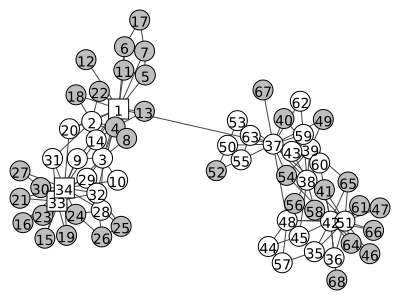

In [327]:
palette = {0: "aqua", 1: "green", 2: "orange", 3: "blue", 4: "brown", 5: "pink", 6: "black"}
palette = "tab10"
# g_zac.vs['color'] = df_descript['comm'].map(palette)
ig.plot(g_zac, layout=g_zac.layout_graphopt(), bbox=(0, 0, 400, 300))

In [328]:
df_descript["showcase"] = np.select(
    [
        (df_descript["node_id"]+1).isin([1, 37]),
        (df_descript["node_id"]+1).isin([2, 39]),
        (df_descript["node_id"]+1).isin([3, 38]),
        (df_descript["node_id"]+1).isin([33, 51]),
        (df_descript["node_id"]+1).isin([34, 42]),
        (df_descript["node_id"]+1).isin([17, 52]),
        (df_descript["node_id"]+1).isin([12, 67]),
        (df_descript["node_id"]+1).isin([25, 44]),
        (df_descript["node_id"]+1).isin([26, 46]),
    ],
    [1, 2,3,4,5,6,7,8,9],
    0,
)

# np.where(df_descript['node_id'].isin([1,2,3,12,17,25,26, 33,34, 37,39,38,42,51,52,67,44,57]), 1, 0)

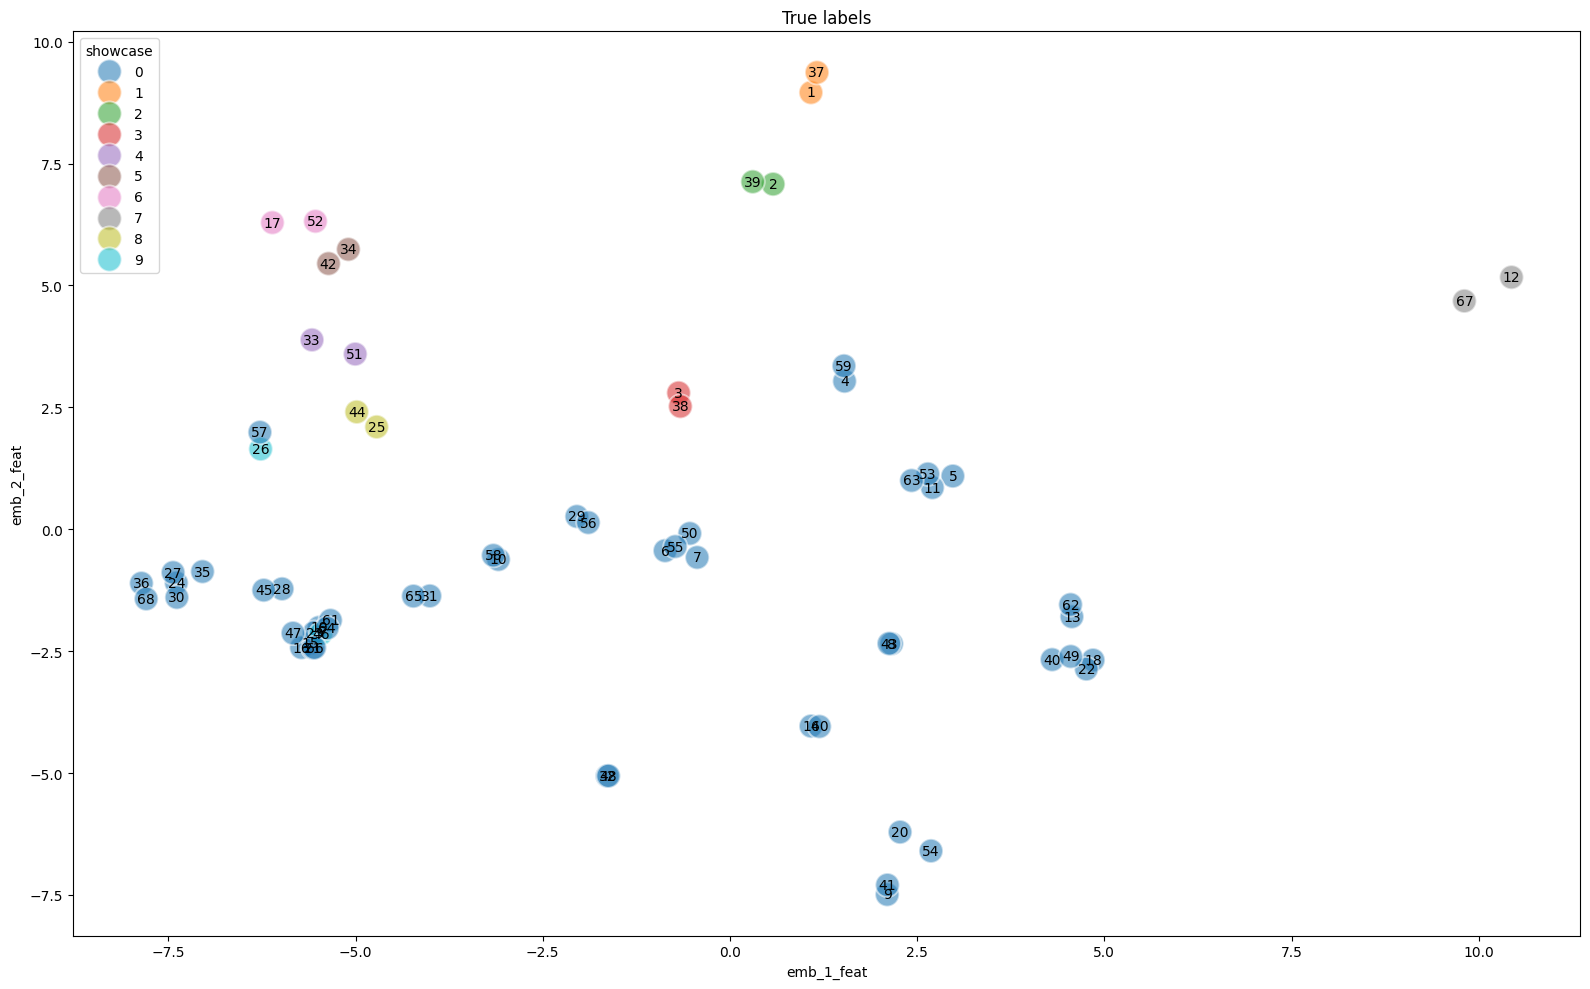

In [337]:
x = embeddings.embeddings_df.iloc[:, 2]
y = embeddings.embeddings_df.iloc[:, 3]

plot(x, y, df_descript["showcase"], palette=palette)

/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


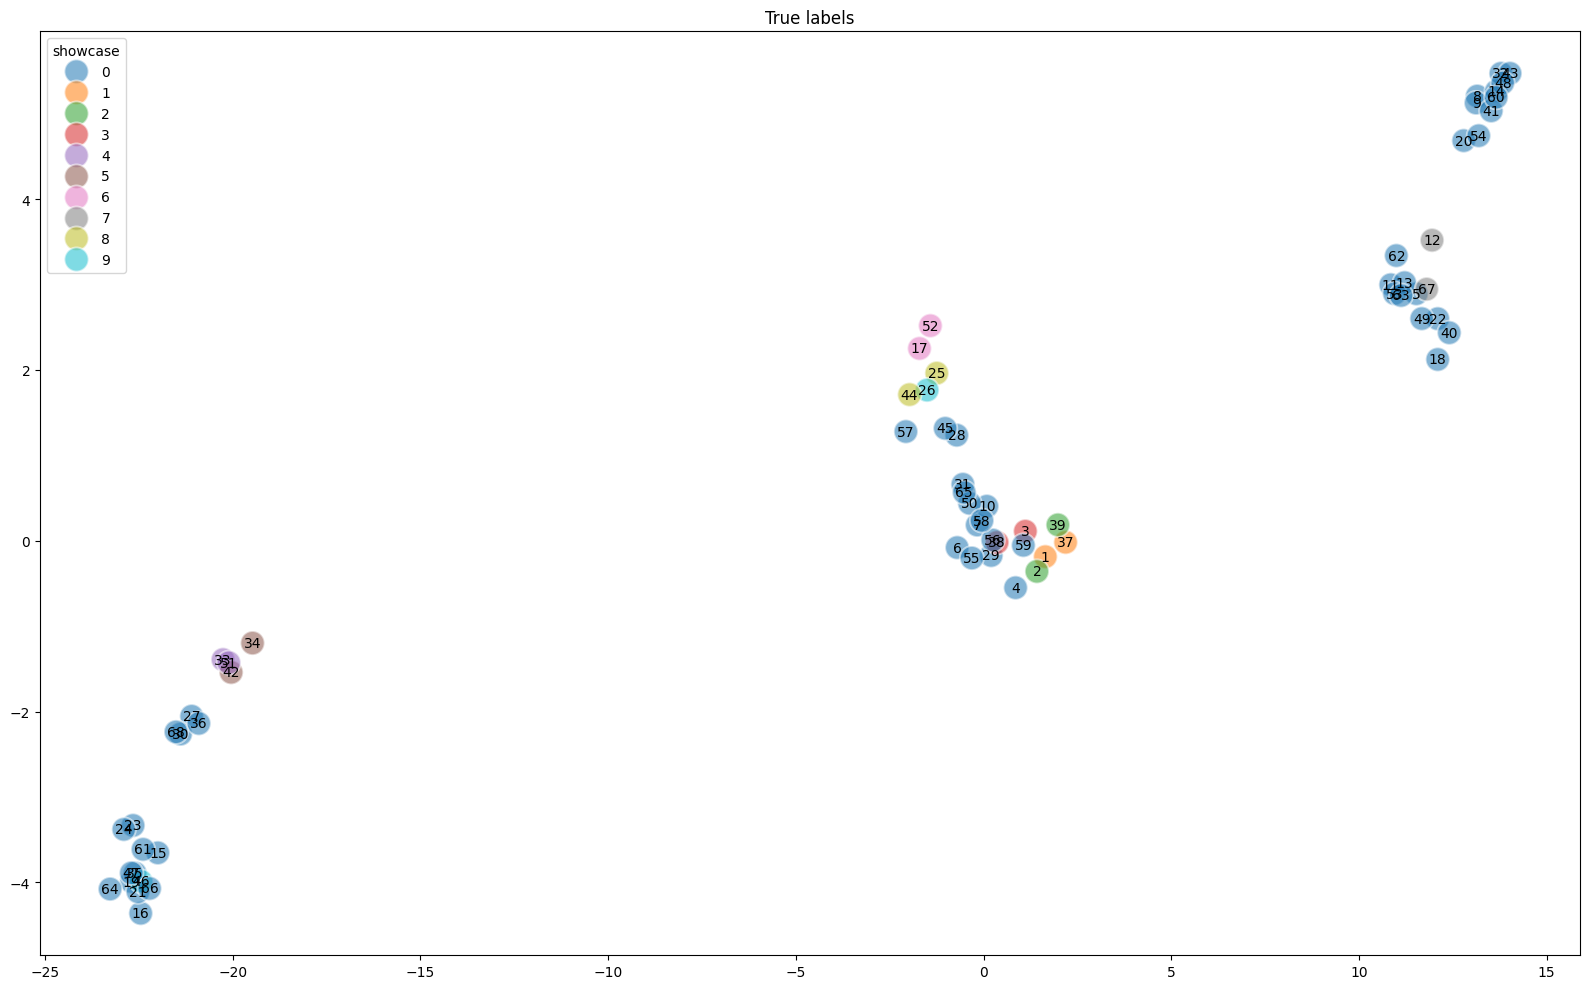

In [330]:
reduced = umap.UMAP().fit_transform(embeddings.embeddings_df.iloc[:, 1:])

x = reduced[:, 0]
y = reduced[:, 1]
plot(x, y, df_descript["showcase"], palette=palette)